In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def calculate_profit(ticker , from_date , to_date):
    filename = ('stocks/{0}.csv').format(ticker)
    data = pd.read_csv(filename)
    data = data.loc[ (data['Date'] >= from_date) & (data['Date'] <= to_date)]
    change_Percent  =  (data.iloc[-1]['Adj Close'] -  data.iloc[0]['Adj Close']) * 100 /  data.iloc[0]['Adj Close']
    print(ticker, np.round(change_Percent,3))
    

In [3]:
df = pd.read_csv('stocks/total_clean.csv', index_col='Unnamed: 0')
df.head()

,Symbol,Date,Close_Rolling,Profit,Range,ReturnPercent,Volume
12363,MMM,2019-01-04,179.112061,0.351242,5.949997,3.951502,2995100.0
12364,MMM,2019-01-07,179.089915,-0.066437,3.639999,-0.230502,2162200.0
12365,MMM,2019-01-08,181.596090,0.692993,4.529999,0.417354,2479800.0
12366,MMM,2019-01-09,181.906199,1.281570,2.559998,0.322417,2163600.0
12367,MMM,2019-01-10,182.766897,2.515656,4.410004,0.671480,1939300.0


In [19]:
def convert_to_univariate_series(df):
    symbol_groups = df.groupby(['Symbol'])

    result= []
    symbols = []

    for name, df_group in symbol_groups:
        X = df_group.iloc[:, 2:7].to_numpy()
        
        normalizer = Normalizer()
        X_ = normalizer.fit_transform(X)
        
        pca = PCA(n_components=1)
        new_X = pca.fit_transform(X_)


        result.append(new_X)
        symbols.append(name)

    data = np.array(result).reshape((len(result), len(result[0])))
    new_df = pd.DataFrame(data, index= symbols)
    return new_df

In [20]:
univariate_df = convert_to_univariate_series(df)

symbols = univariate_df.index.to_numpy()
data = univariate_df.to_numpy()

In [21]:
# define normalizer
normalizer = Normalizer()

# create a K-means model with 20 clusters
kmeans = KMeans(n_clusters=10, max_iter=1000 , n_init = 30)

# make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

In [22]:
pipeline.fit(data)

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=1000, n_clusters=10, n_init=30, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [23]:
# predict cluster labels
labels = pipeline.predict(data)

# create a DataFrame aligning labels & companies
df_result = pd.DataFrame({'Cluster': labels, 'Symbol': symbols})

# display df sorted by cluster labels
df_result.sort_values('Cluster')

,Cluster,Symbol
88,0,CHD
101,0,CNC
422,0,T
325,0,NEE
65,0,BKR
...,...,...
54,9,AXP
57,9,BAC
185,9,FRC
254,9,JPM


In [24]:
def plot_cluster(df, cluster_df , cluster_number = 0):
    
    symbols =  cluster_df[cluster_df['Cluster'] == cluster_number]['Symbol'].tolist()

    sns.set(rc={'figure.figsize':(16, 16)})
    
    cluster_Symbol = pd.DataFrame()
    for s in symbols[:5]: 
        cluster_Symbol[s] = df.loc[s]

    cluster_Symbol.plot(subplots=True, legend=False)
    plt.show()

    for s in symbols: 
        calculate_profit(s , '2019-01-01' , '2019-12-31')

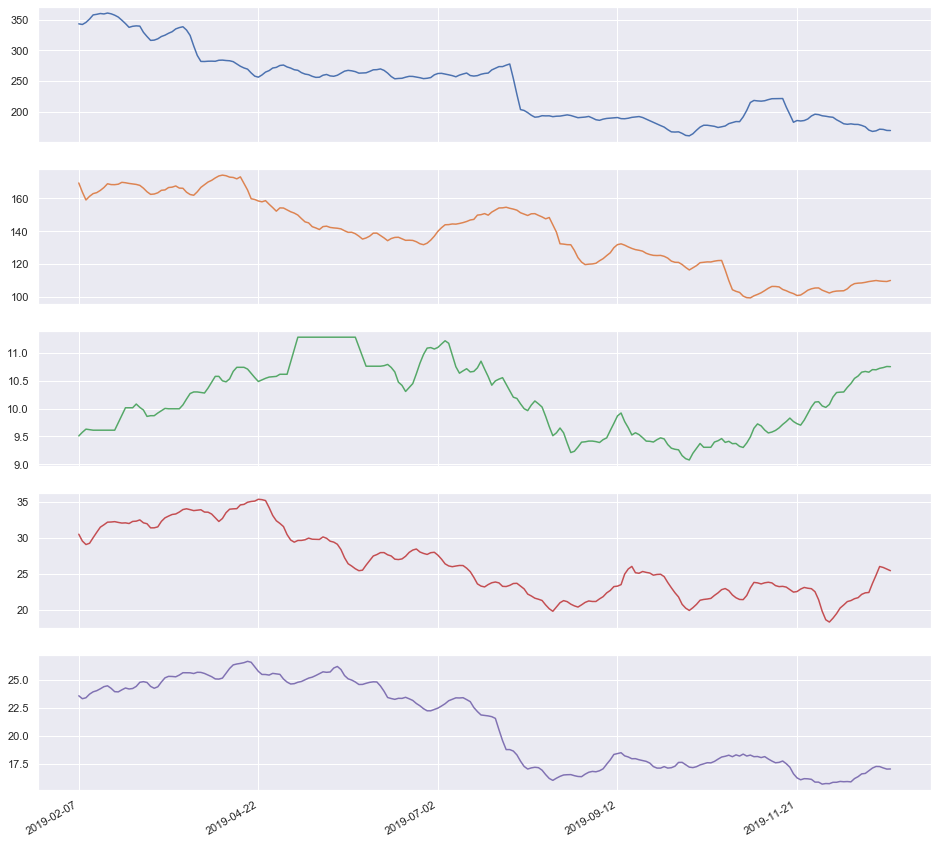

ABMD -44.964
ADS -26.42
AMCR 23.082
APA -2.087
COG -24.753
DXC -29.648
FDX -5.863
GPS -28.083
HAL -7.406
HP 2.039
IFF -1.922
KSS -20.964
LB -26.998
MOS -25.203
MYL -28.009
OXY -29.0
ULTA 2.085
WMB 12.295


In [27]:
df_ = pd.read_csv('stocks/total_data_price_Symbol.csv', index_col='Symbol')
plot_cluster(df_, df_result,3)